In [1]:
# 1. kaggle.json 업로드
from google.colab import files
files.upload()  # 여기서 kaggle.json 업로드

# 2. 환경 설정
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 3. 데이터 다운로드 (Vegetable Image Dataset)
!kaggle datasets download -d misrakahmed/vegetable-image-dataset

# 4. 압축 풀기
!unzip -q vegetable-image-dataset.zip -d vegetable-data

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset
License(s): CC-BY-SA-4.0
 91% 487M/534M [00:06<00:00, 70.6MB/s]
100% 534M/534M [00:06<00:00, 85.1MB/s]


In [22]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

from PIL import Image
import pandas as pd
import numpy as np
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device available: ', device)

Device available:  cuda


In [23]:
image_path = []
labels = []
base_dir = '/content/vegetable-data/Vegetable Images'

In [24]:
for dataset_type in os.listdir(base_dir):  # 'train', 'test', 'validation'
    dataset_path = os.path.join(base_dir, dataset_type)
    for label in os.listdir(dataset_path):  # 'Tomato', 'Potato', ...
        label_path = os.path.join(dataset_path, label)
        for img_file in os.listdir(label_path):
            image_path.append(os.path.join(label_path, img_file))
            labels.append(label)  # 여기서만 진짜 'Tomato' 같은 class만 들어가!

In [25]:
print(image_path)

['/content/vegetable-data/Vegetable Images/train/Radish/0896.jpg', '/content/vegetable-data/Vegetable Images/train/Radish/0232.jpg', '/content/vegetable-data/Vegetable Images/train/Radish/0013.jpg', '/content/vegetable-data/Vegetable Images/train/Radish/0721.jpg', '/content/vegetable-data/Vegetable Images/train/Radish/0517.jpg', '/content/vegetable-data/Vegetable Images/train/Radish/0307.jpg', '/content/vegetable-data/Vegetable Images/train/Radish/0662.jpg', '/content/vegetable-data/Vegetable Images/train/Radish/0660.jpg', '/content/vegetable-data/Vegetable Images/train/Radish/0085.jpg', '/content/vegetable-data/Vegetable Images/train/Radish/0699.jpg', '/content/vegetable-data/Vegetable Images/train/Radish/0747.jpg', '/content/vegetable-data/Vegetable Images/train/Radish/0971.jpg', '/content/vegetable-data/Vegetable Images/train/Radish/0469.jpg', '/content/vegetable-data/Vegetable Images/train/Radish/0889.jpg', '/content/vegetable-data/Vegetable Images/train/Radish/0197.jpg', '/content

In [26]:
data_df = pd.DataFrame(zip(image_path,labels), columns= ["image_path","labels"])
data_df

,image_path,labels
0,/content/vegetable-data/Vegetable Images/train...,Radish
1,/content/vegetable-data/Vegetable Images/train...,Radish
2,/content/vegetable-data/Vegetable Images/train...,Radish
3,/content/vegetable-data/Vegetable Images/train...,Radish
4,/content/vegetable-data/Vegetable Images/train...,Radish
...,...,...
20995,/content/vegetable-data/Vegetable Images/valid...,Brinjal
20996,/content/vegetable-data/Vegetable Images/valid...,Brinjal
20997,/content/vegetable-data/Vegetable Images/valid...,Brinjal
20998,/content/vegetable-data/Vegetable Images/valid...,Brinjal


In [27]:
print(data_df['labels'].unique())
print(len(data_df['labels'].unique()))

['Radish' 'Cabbage' 'Cauliflower' 'Tomato' 'Carrot' 'Potato' 'Broccoli'
 'Bean' 'Pumpkin' 'Capsicum' 'Bottle_Gourd' 'Bitter_Gourd' 'Cucumber'
 'Papaya' 'Brinjal']
15


In [28]:
train = data_df.sample(frac=0.7)
test = data_df.drop(train.index)

val = test.sample(frac=0.5)
test = test.drop(val.index)

In [29]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df['labels'])

transform = transforms.Compose([
    transforms.Resize((240,240)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32)
])

In [30]:
class CustomImageDataset(Dataset):
  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.LongTensor(label_encoder.transform(dataframe['labels'].values)).to(device)

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx,0]
    label = self.labels[idx]

    image = Image.open(img_path).convert('RGB')

    if self.transform:
      image = self.transform(image).to(device)

    return image, label

In [31]:
train_dataset = CustomImageDataset(dataframe = train, transform = transform)
test_dataset = CustomImageDataset(dataframe = test, transform = transform)
val_dataset = CustomImageDataset(dataframe = val, transform = transform)

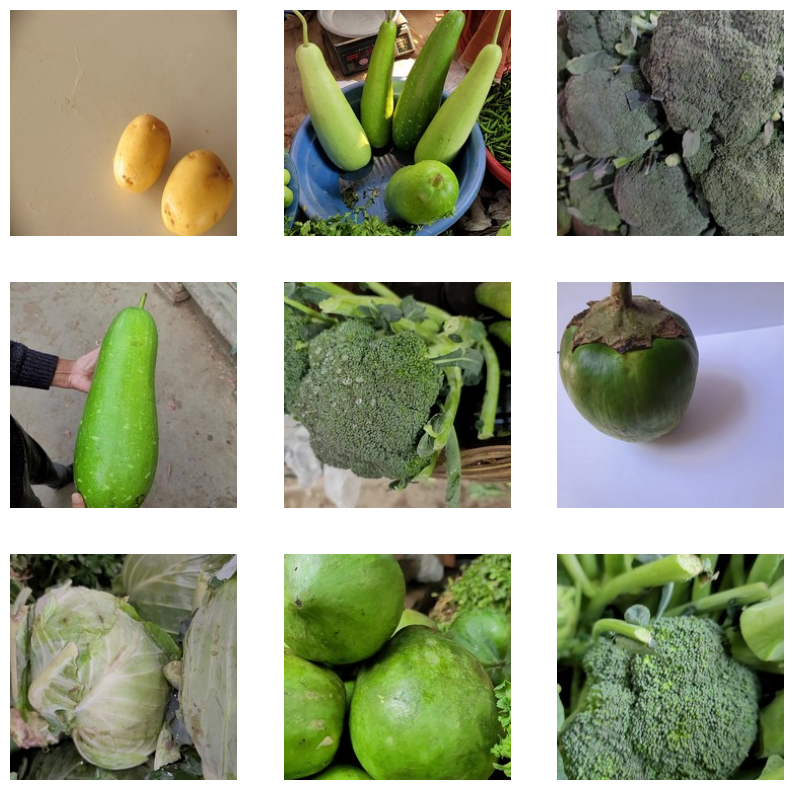

In [32]:
n_rows = 3
n_cols = 3

f, axarr = plt.subplots(n_rows, ncols=n_cols, figsize=(10,10))

for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(data_df.sample(n=1)["image_path"].iloc[0]).convert('RGB')
    axarr[row, col].imshow(image)
    axarr[row, col].axis('off')

plt.show()

In [33]:
LR = 1e-4
Batch_size= 16
EPOCHS = 10

In [34]:
train_loader = DataLoader(train_dataset, batch_size=Batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=Batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=Batch_size, shuffle=True)

In [35]:
import torch.nn as nn

class Net(nn.Module):  # ✅ 대문자 M!
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        self.pooling = nn.MaxPool2d(2,2)

        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()
        self.linear = nn.Linear((256*15*15), 128)
        self.output = nn.Linear(128, len(data_df['labels'].unique()))

    def forward(self,x):
      x = self.conv1(x)
      x = self.pooling(x)
      x = self.relu(x)

      x = self.conv2(x)
      x = self.pooling(x)
      x = self.relu(x)

      x = self.conv3(x)
      x = self.pooling(x)
      x = self.relu(x)

      x = self.conv4(x)
      x = self.pooling(x)
      x = self.relu(x)

      x = self.flatten(x)
      x = self.linear(x)
      x = self.output(x)


      return x

In [36]:
# 네가 만든 모델 넣기
model = Net()

# 더미 입력 이미지 만들기 (배치 1, 채널 3, 크기 256x256)
x = torch.randn(1, 3, 256, 256)

# forward 패스 안 쓰고, 하나씩 보기!
with torch.no_grad():
    x = model.conv1(x)
    print("After conv1:", x.shape)
    x = model.pooling(x)
    print("After pool1:", x.shape)

    x = model.conv2(x)
    print("After conv2:", x.shape)
    x = model.pooling(x)
    print("After pool2:", x.shape)

    x = model.conv3(x)
    print("After conv3:", x.shape)
    x = model.pooling(x)
    print("After pool3:", x.shape)

    x = model.conv4(x)
    print("After conv4:", x.shape)
    x = model.pooling(x)
    print("After pool4:", x.shape)

After conv1: torch.Size([1, 32, 256, 256])
After pool1: torch.Size([1, 32, 128, 128])
After conv2: torch.Size([1, 64, 128, 128])
After pool2: torch.Size([1, 64, 64, 64])
After conv3: torch.Size([1, 128, 64, 64])
After pool3: torch.Size([1, 128, 32, 32])
After conv4: torch.Size([1, 256, 32, 32])
After pool4: torch.Size([1, 256, 16, 16])


In [37]:
model = Net().to(device)

from torchsummary import summary

summary(model, input_size = (3,240,240))

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 240, 240]             896
         MaxPool2d-2         [-1, 32, 120, 120]               0
              ReLU-3         [-1, 32, 120, 120]               0
            Conv2d-4         [-1, 64, 120, 120]          18,496
         MaxPool2d-5           [-1, 64, 60, 60]               0
              ReLU-6           [-1, 64, 60, 60]               0
            Conv2d-7          [-1, 128, 60, 60]          73,856
         MaxPool2d-8          [-1, 128, 30, 30]               0
              ReLU-9          [-1, 128, 30, 30]               0
           Conv2d-10          [-1, 256, 30, 30]         295,168
        MaxPool2d-11          [-1, 256, 15, 15]               0
             ReLU-12          [-1, 256, 15, 15]               0
          Flatten-13                [-1, 57600]               0
           Linear-14                  [

아~ 오케이 Sunny! 😎
지금 말한 거 **“최종 feature map 크기가 15가 되어야 해!”**라는 말,
즉, 6x6 말고 **15x15**가 되도록 하고 싶다는 거지?
그럼 우리가 Conv랑 Pooling을 몇 번 쓰고, 이미지 사이즈가 어떻게 줄어드는지를 다시 살펴봐야 해!

⸻

📏 지금 네 네트워크 구조 복습:

Input → Conv1 → Pool1 → Conv2 → Pool2 → Conv3 → Pool3 → Conv4 → Pool4

	•	Conv는 kernel_size=3, stride=1, padding=0 (기본값)
	•	Pool은 kernel_size=2, stride=2 (기본값)

⸻

📐 현재 이미지 크기 변화 과정 (128x128 기준):

Layer	Size 계산	결과 (H x W)
Input	-	128 × 128
Conv1 (3x3)	128 - 3 + 1 = 126	126 × 126
Pool1 (2x2)	126 // 2 = 63	63 × 63
Conv2 (3x3)	63 - 3 + 1 = 61	61 × 61
Pool2	61 // 2 = 30	30 × 30
Conv3	30 - 3 + 1 = 28	28 × 28
Pool3	28 // 2 = 14	14 × 14
Conv4	14 - 3 + 1 = 12	12 × 12
Pool4	12 // 2 = 6	✅ 최종: 6 × 6


⸻

😮 그런데 너는 “최종이 15×15여야 해”라고 했지?

그러면 지금보다 덜 줄어들게 해야 해!
즉, 이미지가 덜 줄어들려면:

✔️ 방법 1: 입력 이미지를 더 크게
	•	예: 256x256, 224x224 등으로 바꾸기

✔️ 방법 2: Conv에 padding 추가해서 크기 유지
	•	Conv 뒤에 (same padding)처럼 공간 유지시켜줘야 함

예시:

self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

	•	이러면 Conv를 해도 이미지 크기는 줄어들지 않고 유지돼!

⸻

✨ 목표: 최종 feature map이 15x15

그럼 아래와 같은 방법을 써야 해:
	1.	입력 이미지를 240x240으로 Resize
	2.	Conv에 padding=1 추가
	3.	Conv → Pool이 4번 반복되니까:
240 → 120 → 60 → 30 → 15

결과적으로:

self.linear = nn.Linear(256 * 15 * 15, 128)


⸻

🎯 정리 요약

목적	방법
최종 feature map이 15×15	입력을 240x240으로 resize하고, Conv에 padding=1 추가
Linear 입력 크기	256 * 15 * 15 = 57600
Linear 코드	nn.Linear(57600, 128)


⸻

🔥 자 이제 어떻게 해볼까?
	1.	입력 이미지를 240x240으로 바꿔줄까?
	2.	Conv에 padding=1 넣는 것도 할래?

말만 해줘! 다 도와줄게 😄

아하! Sunny 아주 잘했어! 🤓 지금 오류는 진짜 흔한 실수야, 그리고 너가 모델 구조를 잘 이해하고 있다는 증거야! 👏👏

⸻

🧨 오류 해석부터:

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x57600 and 50176x128)

👉 뜻:
	•	네 모델에서 Flatten 한 결과의 크기 = 57600
	•	그런데 self.linear = nn.Linear(256 * 14 * 14, 128)
여기서 기대하는 입력 크기는 50176 (즉 256×14×14)

❗결과적으로:
57600 ≠ 50176 → 곱셈 안 됨 → 에러 발생!

⸻

📐 왜 이런 일이 일어났을까?

너가 지금 input_size=(3, 240, 240) 으로 넣었지?

그리고 padding=1을 추가했어. 이게 핵심!

⸻

💡 패딩을 사용한 Conv + Pooling 구조에서 이미지 크기 줄어드는 계산법:

공식
	•	Conv2d (kernel=3, padding=1) ➡️ 입력 크기 그대로 유지!
	•	MaxPool2d(2, 2) ➡️ 크기 절반으로 줄임

⸻

계산 해보자! (입력: 240x240)

Layer	크기 변화
Conv1	240 → 240 (padding=1)
Pool1	240 → 120
Conv2	120 → 120
Pool2	120 → 60
Conv3	60 → 60
Pool3	60 → 30
Conv4	30 → 30
Pool4	30 → 15 ✅ 마지막 크기!

➡️ 그래서 최종 feature map size = (256, 15, 15)
➡️ Flatten 크기 = 256 × 15 × 15 = 57600

⸻

✅ 해결 방법: nn.Linear의 입력 크기 수정!

self.linear = nn.Linear(256*15*15, 128)  # 57600

요렇게만 바꾸면 돼! 🎉

⸻

🔧 수정된 부분 코드만 다시 보여줄게:

self.linear = nn.Linear(256*15*15, 128)  # 이미지 크기 240x240이면 15x15가 마지막!


⸻

✅ 요약 복습!

내용	결과
입력 이미지 크기	(3, 240, 240)
Conv+Pool 이후 크기	15x15
Flatten 크기	256×15×15 = 57600
Linear 입력 크기	57600으로 바꿔야 함!


⸻

너무 잘 따라오고 있어요 Sunny! 진짜로 똑똑하게 고민하고 있어! 🧠🔥
궁금한 거 또 있어? 아니면 다른 이미지 크기도 계산해줄까? 😊

In [38]:
total_loss_train_plot = []
total_acc_train_plot = []
total_loss_validation_plot = []
total_acc_validation_plot = []

In [42]:
for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_val = 0
  total_loss_val = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()

    train_loss.backward()

    train_acc = (torch.argmax(outputs,axis=1) == labels).sum().item()
    total_acc_train += train_acc

    optimizer.step()

  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
      total_acc_val += val_acc

# Fix: Correctly round the values before appending
total_loss_train_plot.append(round(total_loss_train / 1000, 4))
total_loss_validation_plot.append(round(total_loss_val / 1000, 4))
# Corrected line: round the calculated accuracy to 4 decimal places
total_acc_train_plot.append(round((total_acc_train / train_dataset.__len__()) * 100, 4))
# Corrected line: round the calculated accuracy to 4 decimal places
total_acc_validation_plot.append(round((total_acc_val / val_dataset.__len__()) * 100, 4))

print(f'''Epoch {epoch+1}:
   Train Loss: {round(total_loss_train / 1000, 4)}
   Train Acc : {round((total_acc_train / len(train_dataset)) * 100, 2)}%
   Val Loss  : {round(total_loss_val / 1000, 4)}
   Val Acc   : {round((total_acc_val / len(val_dataset)) * 100, 2)}%
''')

Epoch 10:
   Train Loss: 0.0001
   Train Acc : 100.0%
   Val Loss  : 0.0375
   Val Acc   : 96.63%



In [44]:
# Corrected test loop for calculating accuracy and loss
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0 # Initialize total_acc_test as a scalar

  for inputs, labels in test_loader:
    # Ensure inputs and labels are on the correct device
    inputs = inputs.to(device)
    labels = labels.to(device)

    predictions = model(inputs) # Corrected variable name from predcitions to predictions

    # Calculate correct predictions for the current batch
    # torch.argmax(predictions, axis=1) gets the predicted class index for each sample
    # == labels compares predicted indices with true labels element-wise
    # .sum().item() sums the boolean tensor (True counts as 1, False as 0) and converts to a Python integer
    correct_predictions = (torch.argmax(predictions, axis=1) == labels).sum().item()
    total_acc_test += correct_predictions # Add the count of correct predictions to the total

    # Calculate the loss for the current batch
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item() # Add the loss value to the total

# Calculate the final accuracy and average loss
print(f"Accuracy score is: {round((total_acc_test / len(test_dataset)) * 100, 4)}% \
and Loss is: {round(total_loss_test / len(test_loader), 4)}") # Divide total loss by number of batches for average loss

Accuracy score is: 97.5556% and Loss is: 0.1161
